In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, LambdaLR
from sklearn.metrics import cohen_kappa_score
import timm
import copy



In [2]:
## for removing file if required
import shutil

try:
    shutil.rmtree("/kaggle/working/train")
    
    model_file_to_delete ="/kaggle/working/models"

    if os.path.isfile(model_file_to_delete):
        os.remove(model_file_to_delete)
    
except:
    print("No such directories")

No such directories


# Explatory Data Analysis
## Load Data

In [3]:
def load_data(data_dir):
    train_csv = os.path.join(data_dir, 'train.csv')
    test_csv = os.path.join(data_dir, 'test.csv')
    
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    
    train_dir = os.path.join(data_dir, 'train_images/')
    test_dir = os.path.join(data_dir, 'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))
    
    train['file_name'] = train["id_code"] + ".png"
    test['file_name'] = test["id_code"] + ".png"
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [4]:
data_dir = '/kaggle/input/aptos2019-blindness-detection/'
train_df, test_df = load_data(data_dir)

## Data Shape, Distribution & Visualization

### shape

In [5]:
print(train_df.shape)
train_df.head()

(3662, 4)


,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/tr...,000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/tr...,001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/tr...,0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/tr...,002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/tr...,005b95c28852.png


In [6]:
print(test_df.shape)
test_df.head()

(1928, 3)


,id_code,file_path,file_name
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/te...,0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/te...,003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/te...,006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/te...,00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/te...,009245722fa4.png


### distribution

In [7]:
def plot_dis_classes(df):
    df_group = df['diagnosis'].value_counts().reset_index()
    df_group.columns = ['diagnosis', 'count']

    plt.figure(figsize=(10, 5))
    plt.bar(df_group['diagnosis'], df_group['count'], color='skyblue')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Output Class Distribution')
    plt.show()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


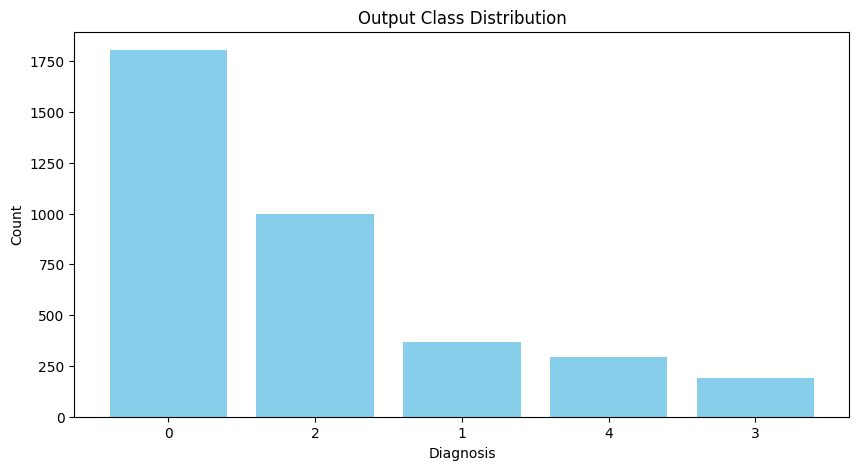

In [8]:
print(train_df['diagnosis'].value_counts())
plot_dis_classes(train_df)

#### Here we can see in the trainig images there is -
1. 1805 images of class 0 - No DR
2. 999 images of class 1 - Mild DR
3. 370 images of class 2 - Moderate DR
4. 295 images of class 3 - Severe DR, and
5. 193 images of class 4 - Proliferative DR

### visualization_function

In [9]:
def visualize_imgs(df, plots_per_class, color_scale, img_size):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(plots_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (plots_per_class*0),pt + (plots_per_class*1), pt + (plots_per_class*2),pt + (plots_per_class*3),pt + (plots_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]), img_size)
                axarr[i].imshow(img,cmap = color_scale)
            else: ## RGB
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((img_size,img_size)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

### Data Visulaization

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


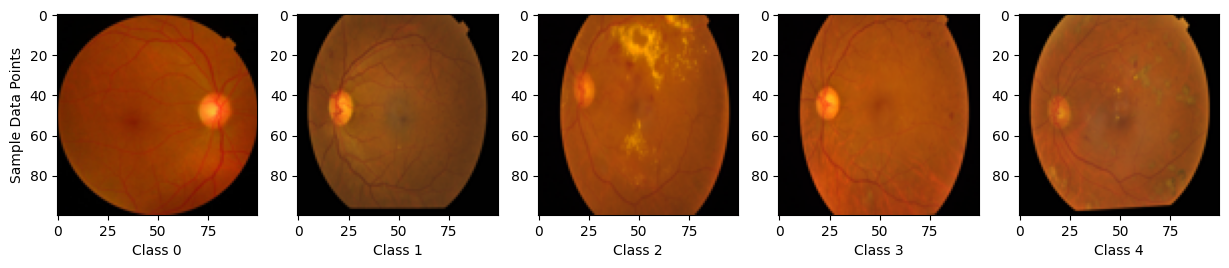

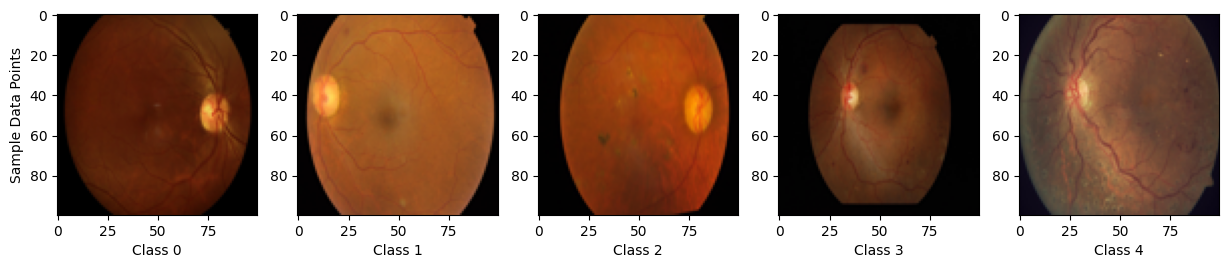

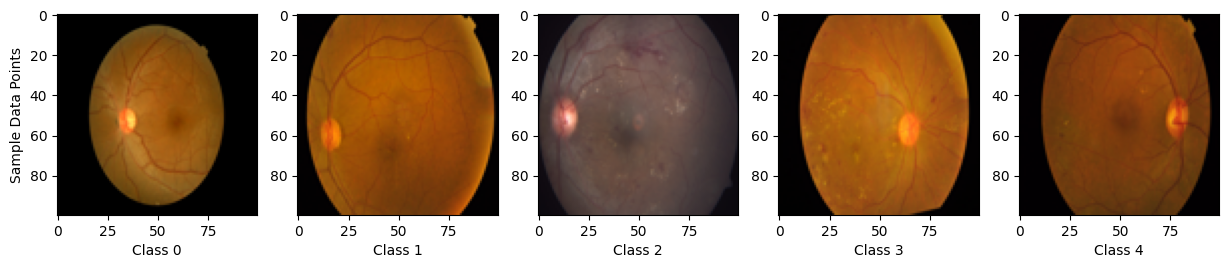

In [10]:
plots_per_class = 3
img_size = 100
visualize_imgs(train_df,plots_per_class,None, img_size)

#### As we can't differentiate much from this RGB images we will look into Grey Scale images for better differentiation.

In [11]:
## function to convert images into grey scale
def convert_to_gray(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size,img_size))
    return img

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


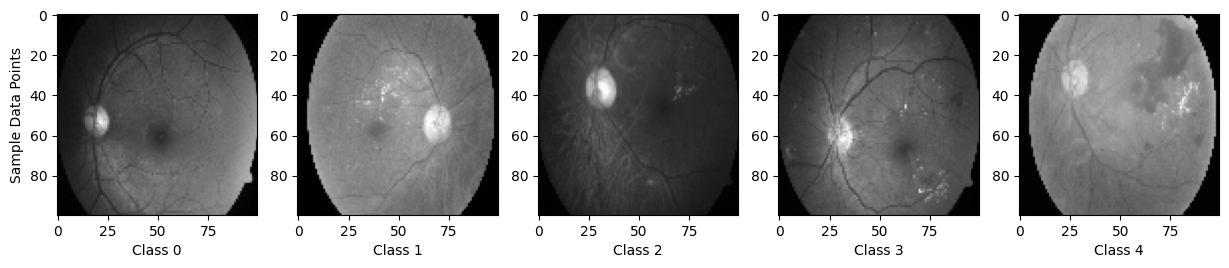

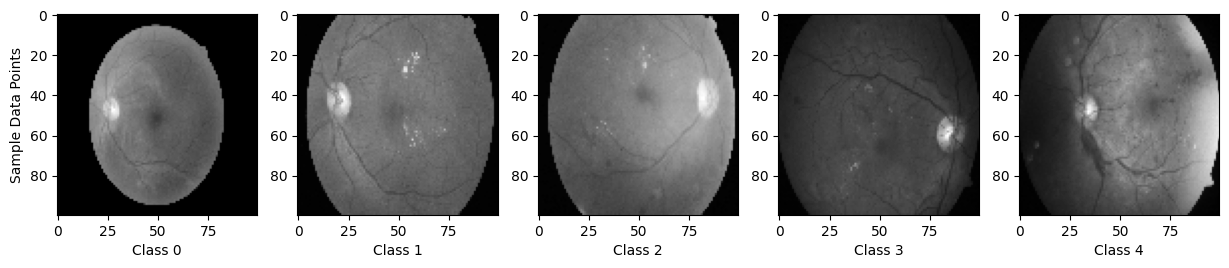

In [12]:
plots_per_class = 2
img_size = 100
visualize_imgs(train_df,plots_per_class,'gray',img_size)

#### Still we can't differentiate much here, so we have to explore for further pre-processing to differentiate between classes.

## Pre-Processing

#### Considering the pictures above we can see that the pictures are not uniforemly captured as technicians traveled to th rureal areas to capture images. Thus we can see there is non-uniforemd shape of the pictures.
#### So we try to remove those unnecessary black borders from the images and crop the image to take up the entirity of the image.

In [13]:
def crop_img(img, percentage):
    
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    threshold = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(threshold, axis=1)
    col_sums = np.sum(threshold, axis=0)
    
    rows = np.where(row_sums > img_arr.shape[1] * percentage)[0]
    cols = np.where(col_sums > img_arr.shape[0] * percentage)[0]
    
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    
    crop_img = img_arr[min_row : max_row + 1, min_col : max_col + 1]
    
    return Image.fromarray(crop_img)

In [14]:
def resize_maintain_aspect(img, desired_size):
    old_width, old_height = img.size
    aspect_ratio = old_width / old_height

    if aspect_ratio > 1:
        new_width = desired_size
        new_height = int(desired_size / aspect_ratio)
    else:
        new_height = desired_size
        new_width = int(desired_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    padded_image = Image.new("RGB", (desired_size, desired_size))
    x_offset = (desired_size - new_width) // 2
    y_offset = (desired_size - new_height) // 2
    padded_image.paste(resized_img, (x_offset, y_offset))
    
    return padded_image

In [15]:
def save_single(args):
    image_path, output_path_folder, percentage, output_size = args
    image = Image.open(image_path)
    
    # Display the image
    #plt.imshow(image)
    #plt.title('Original Image')
    #plt.show()
    
    croped_img = crop_img(image,percentage)
    image_resized = resize_maintain_aspect(croped_img, desired_size=output_size[0])
    
    #print(output_path_folder)
    #print(image_path)
    output_image_path = os.path.basename(image_path)
    # Save the resized image
    output_file_path = os.path.join(output_path_folder, output_image_path)
    #print(output_file_path)
    image_resized.save(output_file_path)

In [16]:
def fast_image_resize(df, output_path_folder, percentage, output_size=None):
    """Uses multiprocessing to make it fast"""
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        return

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)
        
    jobs = []
    for df_item in range(len(df)):
        image_path = df.file_path.iloc[df_item]
        #print(image_path)
        job = (image_path, output_path_folder, percentage, output_size)
        jobs.append(job)
    
    """
    results = []
    for job in tqdm(jobs, total=len(jobs)):
        result = save_single(job)
        results.append(result)
    """
    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

In [17]:
percentage = 0.01
fast_image_resize(train_df, "/kaggle/working/train/images_resized_150/",percentage, output_size=(100, 100))

  0%|          | 0/3662 [00:00<?, ?it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 1/3662 [00:00<10:21,  5.89it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 2/3662 [00:00<15:03,  4.05it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resam

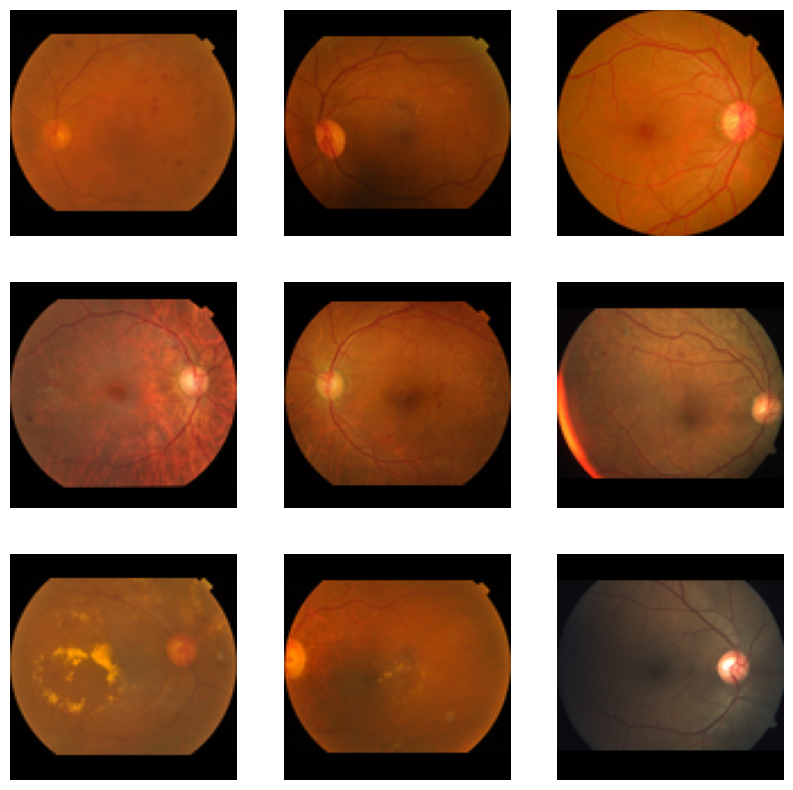

In [18]:
# Path to the directory containing the images
directory = "/kaggle/working/train/images_resized_150"

# Get a list of image filenames in the directory
image_files = os.listdir(directory)

# Define the number of images to display
num_images_to_display = 9

# Display the first few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < len(image_files):
        # Load the image
        img_path = os.path.join(directory, image_files[i])
        img = mpimg.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    else:
        # If there are no more images, remove the axis
        ax.axis('off')

plt.show()

## Model Implementation - Ensambling 
* EfficientNet_b5
* seresnext101_32x4d
* seresnext50_32x4d
* inception_v4
* inception_resnet_v2


In [19]:
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, augmentations=None, max_count=None, test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        #self.augmentations = augmentations
        self.max_count = max_count
        self.test = test
        
        if not test:
            self.class_counts = self.annotations['diagnosis'].value_counts().sort_index()
        else:
            self.class_counts = None
        
        if max_count:
            self.oversample(max_count)
    
    def oversample(self, max_count): ## Over sampling classes to balance
        samples = []
        for diagnosis in self.class_counts.index:
            class_samples = self.annotations[self.annotations['diagnosis'] == diagnosis]
            oversampled_class = class_samples.sample(max_count, replace=True)
            samples.append(oversampled_class)
        self.annotations = pd.concat(samples).reset_index(drop=True)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.test:
            return image
                
        label = int(self.annotations.iloc[idx, 1])
        return image, label

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
pros_img_dir = '/kaggle/working/train/images_resized_150'

In [22]:
## Loading the dataset for determination of the class counts
temp_dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)
class_counts = temp_dataset.class_counts
max_count = class_counts.max()


In [23]:
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform, max_count=max_count)

In [24]:
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

In [25]:
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-3 #5e-4
    elif epoch < 16:
        return 1e-4
    elif epoch < 22:
        return 1e-5
    else:
        return 1e-3

In [26]:
def train_model(model_name,input_size,train_loader,valid_loader, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = select_model(model_name,input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    def lambda_epoch(epoch):
        return lr_schedule(epoch)
    
    def quadratic_weighted_kappa(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    
    scheduler = LambdaLR(optimizer,lr_lambda = lambda_epoch)
    best_kappa = 0.0
    
    for epoch in range(18):
        model.train()
        for images, labels in train_loader:
            if isinstance(images, Image.Image):  # Check if the image is a PIL image
                transform = transforms.ToTensor()
                images = transform(images)
            else:
                images = images
                
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels_epoch = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_labels_epoch.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
        
        #val_predictions.append(val_preds)
        #val_labels.append(val_labels_epoch)
        
        kappa = quadratic_weighted_kappa(val_labels_epoch, val_preds)
        print(f"Epoch {epoch+1}/{18}, Validation Loss: {val_loss / len(valid_loader)}")
        print(f"Validation QWK: {kappa}")
        
        if kappa > best_kappa:
            best_kappa = kappa
            best_model = model.state_dict()
            
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_save_path)
    return model_save_path

In [27]:
# Parameters
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)


In [28]:
def select_model(model_name, input_size):
    if model_name == 'efficientnet_b5':
        return timm.create_model('efficientnet_b5', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'inception_resnet_v2':
        return timm.create_model('inception_resnet_v2', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'inception_v4':
        return timm.create_model('inception_v4', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'seresnext50_32x4d':
        return timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'seresnext101_32x4d':
        return timm.create_model('seresnext101_32x4d', pretrained=True, num_classes=5, in_chans=3)
    else:
        raise ValueError(f"Unknown model name {model_name}")

In [ ]:
models_to_train = [
    ('efficientnet_b5', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

In [48]:
models_to_train = [
    ('seresnext101_32x4d', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

Epoch 1/13, Validation Loss: 1.3548080272841871
Validation QWK: 0.5537507749535028
Epoch 2/13, Validation Loss: 1.1347168140244066
Validation QWK: 0.6999866363757852
Epoch 3/13, Validation Loss: 0.9780737830881487
Validation QWK: 0.7833843695912661
Epoch 4/13, Validation Loss: 0.8407073345100671
Validation QWK: 0.8432995194874533
Epoch 5/13, Validation Loss: 0.7201843157149198
Validation QWK: 0.8831763122476447
Epoch 6/13, Validation Loss: 0.6134655899123141
Validation QWK: 0.9033301874073075
Epoch 7/13, Validation Loss: 0.522016095487695
Validation QWK: 0.9285906763675559
Epoch 8/13, Validation Loss: 0.44275017866962835
Validation QWK: 0.9461663947797716
Epoch 9/13, Validation Loss: 0.37031819292327817
Validation QWK: 0.9609045089224901
Epoch 10/13, Validation Loss: 0.30374728744490104
Validation QWK: 0.9678474114441417
Epoch 11/13, Validation Loss: 0.3068534177646302
Validation QWK: 0.9697216564833673
Epoch 12/13, Validation Loss: 0.30080353612439675
Validation QWK: 0.967794537301263

In [29]:
models_to_train = [
    ('seresnext50_32x4d', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

Epoch 1/18, Validation Loss: 1.5757624057301305
Validation QWK: 0.36953831508805335
Epoch 2/18, Validation Loss: 1.5345338311111718
Validation QWK: 0.4498101450686398
Epoch 3/18, Validation Loss: 1.4892550811432956
Validation QWK: 0.5017078561382359
Epoch 4/18, Validation Loss: 1.4341517435876947
Validation QWK: 0.5541835213966362
Epoch 5/18, Validation Loss: 1.378776228218748
Validation QWK: 0.6052805280528053
Epoch 6/18, Validation Loss: 1.3368061969154759
Validation QWK: 0.6370070778564206
Epoch 7/18, Validation Loss: 1.3015437544437878
Validation QWK: 0.6619341324333761
Epoch 8/18, Validation Loss: 1.2621102751347058
Validation QWK: 0.6943119266055047
Epoch 9/18, Validation Loss: 1.2349958775336283
Validation QWK: 0.7511122095897182
Epoch 10/18, Validation Loss: 1.2063528654868143
Validation QWK: 0.7587582595686324
Epoch 11/18, Validation Loss: 1.2021252356077496
Validation QWK: 0.7553164873655241
Epoch 12/18, Validation Loss: 1.1989651280536986
Validation QWK: 0.7538093439113462
E

In [30]:
models_to_train = [
    ('inception_v4', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch 1/18, Validation Loss: 1.5721088166822468
Validation QWK: 0.2588824020016679
Epoch 2/18, Validation Loss: 1.4931432343365854
Validation QWK: 0.5925494761350407
Epoch 3/18, Validation Loss: 1.3355102894598978
Validation QWK: 0.6762010552624271
Epoch 4/18, Validation Loss: 1.2134338857834799
Validation QWK: 0.7570297570297571
Epoch 5/18, Validation Loss: 1.1029125995803297
Validation QWK: 0.7847033206314643
Epoch 6/18, Validation Loss: 0.9992254867888334
Validation QWK: 0.80923118940325
Epoch 7/18, Validation Loss: 0.9289588970050477
Validation QWK: 0.8469222462203023
Epoch 8/18, Validation Loss: 0.8671131144490158
Validation QWK: 0.8689148762578189
Epoch 9/18, Validation Loss: 0.7981789671538169
Validation QWK: 0.8864130434782609
Epoch 10/18, Validation Loss: 0.7422506804006141
Validation QWK: 0.8885865868589308
Epoch 11/18, Validation Loss: 0.7066760476221118
Validation QWK: 0.8903467666354264
Epoch 12/18, Validation Loss: 0.7036486456268712
Validation QWK: 0.8990578734858681
Epo

In [31]:
models_to_train = [
    ('inception_resnet_v2', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Epoch 1/18, Validation Loss: 1.5350559343371475
Validation QWK: 0.3616659583510412
Epoch 2/18, Validation Loss: 1.4328227084979677
Validation QWK: 0.5408934707903781
Epoch 3/18, Validation Loss: 1.304585295811034
Validation QWK: 0.6208731406457855
Epoch 4/18, Validation Loss: 1.2048225319176389
Validation QWK: 0.66576852418861
Epoch 5/18, Validation Loss: 1.121910692306987
Validation QWK: 0.7008310249307479
Epoch 6/18, Validation Loss: 1.031955455478869
Validation QWK: 0.7523701175578309
Epoch 7/18, Validation Loss: 0.9664055903752645
Validation QWK: 0.7723798419484389
Epoch 8/18, Validation Loss: 0.8732465254633051
Validation QWK: 0.7811413113487053
Epoch 9/18, Validation Loss: 0.7841865138003701
Validation QWK: 0.8078328981723237
Epoch 10/18, Validation Loss: 0.6912655380734226
Validation QWK: 0.828888302086084
Epoch 11/18, Validation Loss: 0.677244493313003
Validation QWK: 0.8452004219409283
Epoch 12/18, Validation Loss: 0.6731765887193513
Validation QWK: 0.8358793576184881
Epoch 13